# ECE661 PyTorch Demo: Train an MNIST Classifier

In this tutorial, we will step through the process of training and testing a simple MNIST classifier with PyTorch. Feel free to modify hyperparameters, add `print` statements, and experiment with the base code.

You can use this as a reference, but please **DO NOT** copy code directly for your assignments.

## Imports
Start by importing the necessary PyTorch modules.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

print("PyTorch version:", torch.__version__)

PyTorch version: 1.9.0


## Setup device
If GPUs (w/ CUDA) are available we will use them. If not, set the device to CPU. Initializing the `device` object this way makes the code system agnostic.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## Define Model
Next, we will build a small custom CNN.

When building a model, we make it a sub-class of `nn.Module` and override two functions: `__init__` and `forward`:
- `__init__` is the model constructor. Here, we first call the parent's constructor then define our layers. This can be thought of as creating the nodes of our computational graph.
- `forward` defines the forward pass of our network. In other words, this defines the connections between the nodes (layers) of our computation graph. Must return a tensor.

Keep in mind that there are many ways to define a PyTorch model based on user preference. For example, you can combine blocks using PyTorch's [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) interface. Another user choice is whether to define layers as `nn.Module` objects or to manually instantiate weight tensors and use the `nn.functional` interface for added flexibility. The beauty of PyTorch is that it allows users to use a combination of the many interfaces in the same model.

In this example, we use a common PyTorch design pattern which is to construct layers that have associated learnable parameters (e.g., convolutional layers, fully connected layers) in the constructor (`__init__`), and use the `nn.functional` interface for layers that do not have learnable parameters (e.g., pooling layers, activation functions). Note, however, that defining the max pool layers in the constructor as `nn.MaxPool2d` objects will lead to _identical_ results.

When defining your PyTorch model, always refer to the [PyTorch docs](https://pytorch.org/docs/stable/index.html) to assure that you are using the modules/functions correctly. As an example, check out the [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=nn%20conv2d#torch.nn.Conv2d) page for a reference to the argument order, types and shapes that this module expects.

In [3]:
# Define MyNet model class
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # First conv layer should expect 1 input channel, as MNIST images are greyscale
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # conv2's in_channels should match conv1's out_channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Note that before passing conv2's output to fc1 we will flatten it
        # So the input size will be feature_height*feature_width*feature_depth 
        # We can compute this by hand (note input is 1x28x28): 64x7x7=3136)
        self.fc1 = nn.Linear(in_features=(64*7*7), out_features=128)
        # This is the last FC layer, so the output size must == num_classes == 10
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Forward thru conv1
        x = self.conv1(x)
        # Apply ReLU activation on the output
        x = F.relu(x)
        # Downsample feature's spatial extent w/ max pool
        x = F.max_pool2d(x, kernel_size=2)
        
        # Forward thru conv2
        x = self.conv2(x)
        # Apply ReLU activation on the output
        x = F.relu(x)
        # Downsample feature's spatial extent w/ max pool
        x = F.max_pool2d(x, kernel_size=2)
        
        # Flatten conv feature here
        x = torch.flatten(x, 1)
        # Forward thru fc1
        x = self.fc1(x)
        # Apply ReLU activation on the output
        x = F.relu(x)
        # Forward thru fc2
        x = self.fc2(x)
        return x
    

# Construct a MyNet instance on the correct device
model = MyNet().to(device)
# Print nodes in model's graph
print(model)

MyNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Initialize loss function and optimizer

The next step is to initialize our loss function (`criterion`) and optimizer.
- For the `criterion` we use `nn.CrossEntropyLoss`, which combines `nn.LogSoftmax` with `nn.NLLLoss`.
- We use an `SGD` optimizer with learning rate 0.01.

In [4]:
# Construct loss function object
criterion = nn.CrossEntropyLoss().to(device)

# Construct optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Prepare data and data loading process

In this example we are training an MNIST classifier. PyTorch provides easy access to popular benchmark datasets via [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html#).

Now that we have our model and learning criterion established, we can prepare the data and data loading process. The first step is to define our `transform` class where we define the input preprocessing that we desire for each input. In our case, we simply convert the data to a tensor and normalize the data about the precalculated mean and std of each channel in the training set (this can usually be looked up). 

The next step is to construct PyTorch `Datasets`, which stores the data in memory. We set the `download` flags to true, which will download the data to the specified path if PyTorch cannot find already find it there.

We also need to construct a `DataLoader`s for both the train and test `Dataset`. The role of the `DataLoader` is to wrap an iterable around the `Dataset` so that we can easily serve the data up in batches. This is where we set the batch size, and `shuffle` flag. Typically, we shuffle training data to help with convergence.

In [5]:
# Define preprocessing
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
        ])

# Load data into datasets
train_dataset = datasets.MNIST('./', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)

# Construct dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

C:\Users\Administrator\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## [Optional] Visualize data

Here we investigate what a batch of our training data looks like.

Notice that our `images` tensor contains the normalized image data, and has shape NxCxHxW, and the `targets` tensor is essentially a list of corresponding target class labels with shape N (batch_size).

images: tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


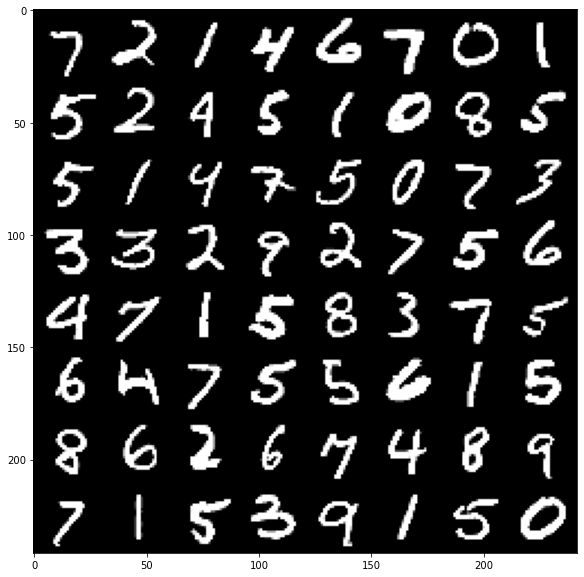

In [6]:
# Grab a batch of training data
images, targets = next(iter(train_loader))
print("images:", images[0], images.shape)
print("targets:", targets, targets.shape)

# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 8)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Train model

Finally we can train our model. 

Training is typically done by looping over a specified number of epochs. In each epoch, we iterate over all batches of the training data and update the model. 

Note that for each batch, we must:
- Move data to correct device.
- Zero out old gradients (they accumulate by default).
- Forward pass input through model.
- Compute loss w.r.t. the current targets.
- Backward pass the loss to get compute gradients.
- Update parameters using gradients and our optimizer.

We will also track average training loss and accuracy for each epoch.

In [7]:
epochs = 3

for i in range(1, epochs+1):
    # Put model in train mode
    model.train()
    print("\nEpoch [{}/{}]".format(i, epochs))

    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    
    # Train the training dataset for 1 epoch.
    for batch_idx, (images, targets) in enumerate(train_loader):
        # Copy inputs to device
        images = images.to(device)
        targets = targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass images through model
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        #print("targets:", targets, targets.shape)
        #print("predicted:", predicted, predicted.shape)
        correct = predicted.eq(targets).sum()
        #print("correct:", correct)
        # Append to totals
        total_ims += targets.shape[0]
        total_batches += 1
        total_loss += loss
        total_corrects += correct.item()
        # Print every 100 batches
        if batch_idx % 100 == 0:
            print("batch: {}".format(batch_idx), "\tloss: {}".format(loss.item()))
    
    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, acc))


C:\Users\Administrator\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch [1/3]
batch: 0 	loss: 2.3402822017669678
batch: 100 	loss: 1.132285714149475
batch: 200 	loss: 0.5776624083518982
batch: 300 	loss: 0.3585170805454254
batch: 400 	loss: 0.3134666085243225
batch: 500 	loss: 0.15582013130187988
batch: 600 	loss: 0.23048344254493713
batch: 700 	loss: 0.24067215621471405
batch: 800 	loss: 0.18424224853515625
batch: 900 	loss: 0.23631635308265686
Training loss: 0.5165, Training accuracy: 85.9733

Epoch [2/3]
batch: 0 	loss: 0.11686941236257553
batch: 100 	loss: 0.10394467413425446
batch: 200 	loss: 0.16982777416706085
batch: 300 	loss: 0.08233356475830078
batch: 400 	loss: 0.18000467121601105
batch: 500 	loss: 0.06359383463859558
batch: 600 	loss: 0.177804633975029
batch: 700 	loss: 0.1492934376001358
batch: 800 	loss: 0.1281498819589615
batch: 900 	loss: 0.12698660790920258
Training loss: 0.1523, Training accuracy: 95.3567

Epoch [3/3]
batch: 0 	loss: 0.03931356221437454
batch: 100 	loss: 0.10657083988189697
batch: 200 	loss: 0.14187155663967133
bat

## Test model

Now that we have a trained model, we can test its performance on the test set.

To do this we use a similar loop to our training procedure, but we do not need to compute gradients or update the model.

In [8]:
# Make this a function so we can re-use later (can do this for training too)
def test_model(model):
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0

    # Put model in eval mode
    model.eval()

    # Do NOT compute gradients
    with torch.no_grad():
        # Run inference on each image in the test set (use batches to make process faster)
        for batch_idx, (images, targets) in enumerate(test_loader):
            # Copy inputs to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass images through model
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, targets)
            # Calculate correct predictions
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            # Append to totals
            total_ims += targets.shape[0]
            total_batches += 1
            total_loss += loss
            total_corrects += correct.item()

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0
    print("Test loss: %.4f, Test accuracy: %.4f" %(avg_loss, acc))

    
# Call test_model
test_model(model)

Test loss: 0.0872, Test accuracy: 97.5600


## Saving and loading models

The last basic procedure that we will cover is how to save and load PyTorch models. 

In this example, we wish to save the model to disk to be used for inference later. To do this, we simply use `torch.save` to save the model's `state_dict`, which is a Python dictionary that contains all of the parameters of the module.



For a detailed outline on the many ways to save and load models (e.g., save/load across devices, save/load for finetuning, etc.), see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html). 

In [9]:
# Save model
torch.save(model.state_dict(), "./demo_model.pt")

To demonstrate the loading process we will construct a new `MyNet`, test it, then load the saved parameters and re-test to prove that the parameters loaded correctly.

In [10]:
# Create new MyNet
model2 = MyNet().to(device)

# Test un-trained model2
print("Before loading...")
test_model(model2)

# Load parameters
model2.load_state_dict(torch.load("./demo_model.pt"))
model2.eval()  # Remember to set model to eval mode (train mode is default)
# Re-test un-trained model2
print("\nAfter loading...")
test_model(model2)

Before loading...
Test loss: 2.3164, Test accuracy: 4.9700

After loading...
Test loss: 0.0872, Test accuracy: 97.5600


## Conclusion

Congratulations, now you know the basics of PyTorch! 

Remember to use the [PyTorch docs](https://pytorch.org/docs/stable/index.html) to learn about new functions and to avoid silly mistakes. The [PyTorch discuss] forum is also a useful resource. 

Good luck!